In [18]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [35]:
%matplotlib inline

import itertools
from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from skimage.segmentation import watershed, slic
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import decomposition
from population import unit_activity_matrix
from psth import get_psth_matrix
from spiketrain import smooth_gaussian, smooth_rectangular

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [22]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

# manuscript session
# '009266_hippoSIT_2023-04-18_10-10-37'

all_selected = selected_009266 + selected_009265 + selected_57
selected = all_selected[:100]
selected[:4]

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51']

In [23]:
electrodes_A1 = {
    '009265': [1, 2],
    '009266': [1, 2],
    '57': [1]
}

## Single session - playground

In [24]:
session = all_selected[1]
#session = selected_57[17]
#session = '009265_hippoSIT_2023-03-05_11-52-17'
electrodes = [1]

animal   = session.split('_')[0]
session_path = os.path.join(source, animal, session)
psth_file  = os.path.join(session_path, 'analysis', 'psth_micro.h5')
unit_file  = os.path.join(session_path, 'units.h5')
meta_file  = os.path.join(session_path, 'meta.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    cfg = json.loads(f['processed'].attrs['parameters'])

spike_times = {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f if int(x.split('-')[0]) in electrodes]
with h5py.File(unit_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name]['spike_times'])
        
session

'009266_hippoSIT_2023-04-18_10-10-37'

## 1. Evoked activity

In [25]:
# compute activity matrix
bin_size = 0.01
latency  = cfg['sound']['latency']  # seconds
bins_per_event = int(latency / bin_size)
bins, unit_mx = unit_activity_matrix(meta_file, unit_file, electrodes_A1[animal], bin_size=bin_size)
    
# z-score
for i in range(len(unit_mx)):
    unit_mx[i] = stats.zscore(unit_mx[i])

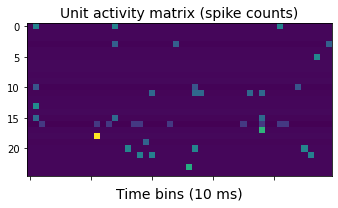

In [44]:
x_l, x_r = 30, 35  # in seconds

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

im = ax.imshow(unit_mx[:, x_l*100:x_r*100 - 450])
ax.set_xlabel('Time bins (10 ms)', fontsize=14)
ax.set_title('Unit activity matrix (spike counts)', fontsize=14)
ax.set_xticklabels([])
#ax.set_yticks(np.arange(1, unit_mx.shape[0], 5))
#ax.set_yticklabels(np.arange(unit_mx.shape[0]))

#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_unit_mx.png' % session[-19:-6]), dpi=300)

In [45]:
unit_mx_sm = unit_mx.copy()
for i in range(unit_mx.shape[0]):
    unit_mx_sm[i] = stats.zscore(unit_mx[i])
    unit_mx_sm[i] = smooth_rectangular(unit_mx[i], 500)  # in 10ms bins

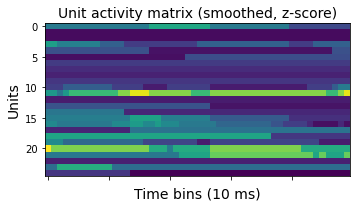

In [43]:
x_l, x_r = 30, 35  # in seconds

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.imshow(unit_mx_sm[:, x_l*100:x_r*100 - 450])
ax.set_xlabel('Time bins (10 ms)', fontsize=14)
ax.set_title('Unit activity matrix (smoothed, z-score)', fontsize=14)
ax.set_xticklabels([])
ax.set_ylabel('Units', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_unit_mx_smooth.png' % session[-19:-6]), dpi=300)

In [ ]:
su_mx = unit_mx_sm[:, 1::2].T
pca = decomposition.PCA(n_components=3)
pca.fit(su_mx)
X = pca.transform(su_mx)
sustained_act = X[:, 0]  # PC1 score

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(fit[idxs_sil_ev][:, 1])

In [181]:
psth_bins, psths_all = get_psth_matrix(psth_file, electrodes_A1[animal])
conditions = list(psths_all.keys())

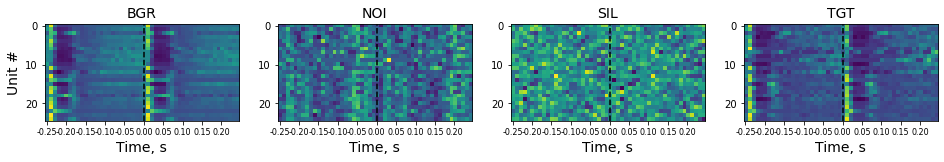

In [182]:
fig, axes = plt.subplots(1, len(conditions), figsize=(16, 4))

for k, cond in enumerate(conditions):
    ax = axes[k]
    ax.imshow(psths_all[cond])
    ax.set_xlabel('Time, s', fontsize=14)
    if k == 0:
        ax.set_ylabel('Unit #', fontsize=14)
    ax.set_xticks(np.arange(len(psth_bins[::5]))*5)
    _ = ax.set_xticklabels(["%.2f" % b for b in psth_bins[::5]], fontsize=8)
    ax.axvline(25, color='black', ls='--')
    ax.set_title("%s" % cond, fontsize=14)

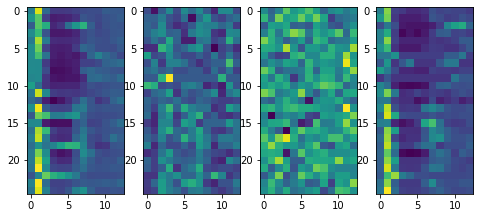

In [183]:
# taking only the evoked part?
# indices of half width
idx_s = int(psths_all[cond].shape[1]/2)
idx_e = idx_s + int(np.ceil(idx_s/2))
fig, axes = plt.subplots(1, len(conditions), figsize=(8, 4))

for k, cond in enumerate(conditions):
    axes[k].imshow(psths_all[cond][:, idx_s:idx_e])

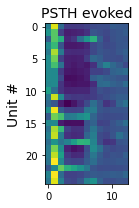

In [244]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))

ax.imshow(psths_all['BGR'][:, idx_s:idx_e])
ax.set_ylabel('Unit #', fontsize=14)
ax.set_title('PSTH evoked', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_profile_mx.png' % session[-19:-6]), dpi=300)

In [184]:
# CCR matrix for all units
CCR_mx_all = {}

for k, cond in enumerate(conditions):
    CCR_mx = np.zeros(unit_mx.shape)
    for unit_idx in range(unit_mx.shape[0]):
        prof = psths_all[cond][:, idx_s:idx_e][unit_idx]  # evoked part only
        #prof = psths_all[cond][unit_idx]  # all
        spks = unit_mx[unit_idx]
        CCR_mx[unit_idx] = signal.correlate(spks, prof, mode='same')
        
    CCR_mx_all[cond] = CCR_mx

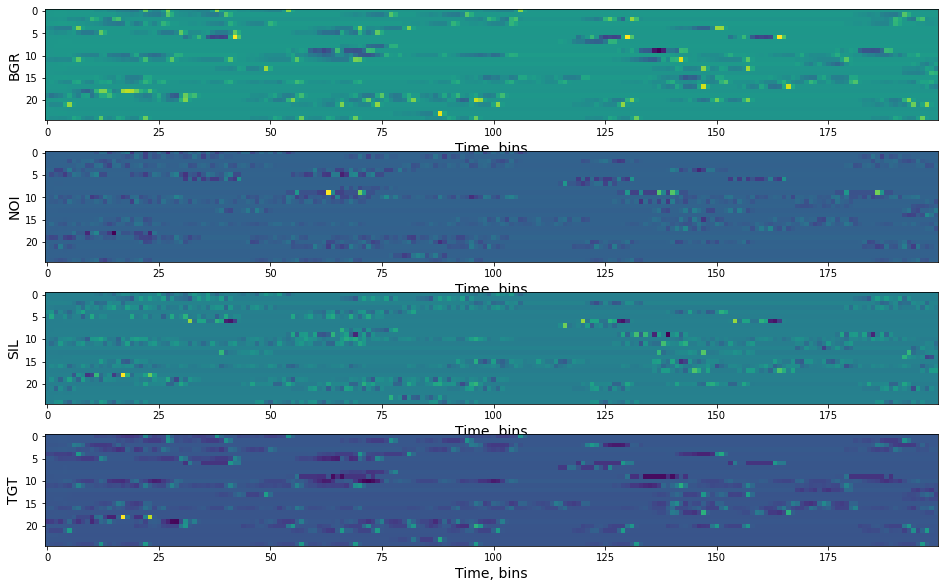

In [185]:
fig, axes = plt.subplots(4, 1, figsize=(16, 10))

for k, cond in enumerate(conditions):
    ax = axes[k]
    ax.imshow(CCR_mx_all[cond][:, 0:200])
    ax.set_ylabel(cond, fontsize=14)
    ax.set_xlabel('Time, bins', fontsize=14) 

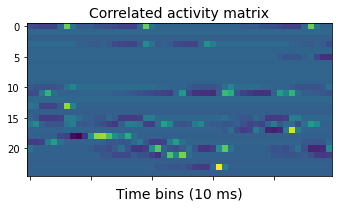

In [243]:
x_l, x_r = 30, 35  # in seconds

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.imshow(CCR_mx_all['BGR'][:, x_l*100:x_r*100 - 450])
ax.set_xlabel('Time bins (10 ms)', fontsize=14)
ax.set_title('Correlated activity matrix', fontsize=14)
ax.set_xticklabels([])

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_CCR_mx.png' % session[-19:-6]), dpi=300)

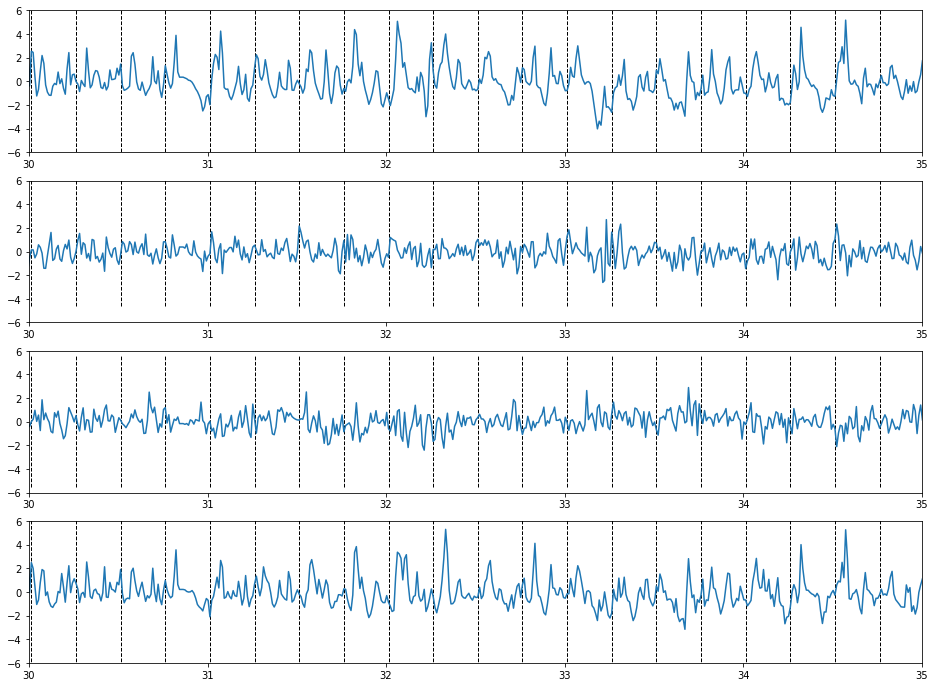

In [196]:
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
x_l, x_r = 30, 35
    
for k, cond in enumerate(conditions):
    sig = CCR_mx_all[cond].mean(axis=0)

    ax = axes[k]
    ax.plot(bins[:-1], sig)
    ax.vlines(bins[::bins_per_event] + 0.0, sig.min(), sig.max(), color='black', lw=1, ls='--', label='Stimulus')
    ax.set_xlim(x_l, x_r, 10)
    ax.set_ylim(-6, 6)

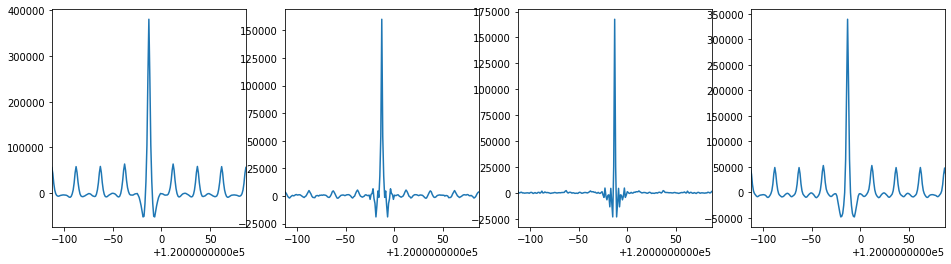

In [165]:
# autocorrs
fig, axes = plt.subplots(1, len(conditions), figsize=(16, 4))

for k, cond in enumerate(conditions):
    sig = CCR_mx_all[cond].mean(axis=0)
    autocorr = signal.correlate(sig, sig, mode='same')
    half_p = int(len(autocorr)/2)
    
    ax = axes[k]
    ax.plot(autocorr)
    ax.set_xlim(half_p - 100, half_p + 100)

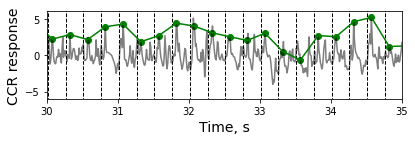

In [245]:
# selected for the manuscript
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
x_l, x_r = 30, 35
offset = 6
    
sig = CCR_mx_all['BGR'].mean(axis=0)

ax.plot(bins[:-1], sig, color='black', alpha=0.5, lw=1.5)
ax.vlines(bins[::bins_per_event] + 0.0, sig.min(), sig.max(), color='black', lw=1, ls='--', label='Stimulus')
ax.scatter(bins[offset::bins_per_event], sig[offset::bins_per_event], color='green')
ax.plot(bins[offset::bins_per_event], sig[offset::bins_per_event], color='green')
ax.set_xlim(x_l, x_r)
ax.set_ylim(-6, 6)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('CCR response', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_CCR_response.png' % session[-19:-6]), dpi=300)

In [166]:
evoked_resp = np.zeros(len(sound_events))

event_ids = {'BGR': 1, 'TGT': 2, 'SIL': 0, 'NOI': -1}

for k, cond in enumerate(conditions):
    sig = CCR_mx_all[cond].mean(axis=0)
    sig_cond = sig[6::bins_per_event]

    ev_id = event_ids[cond]
    ev_idxs = np.where(sound_events[:, 1] == ev_id)[0]
    for idx in ev_idxs:
        evoked_resp[idx] = sig_cond[idx]

In [167]:
# smooth?
k_width = 25  # sampled as events!

kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
evoked_resp_sm = np.convolve(evoked_resp, kernel, 'same') / kernel.sum()

(0.0, 2000.0)

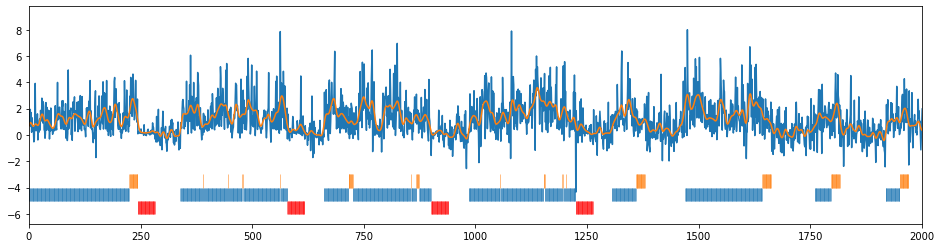

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

colors = {'BGR': 'tab:blue', 'TGT': 'tab:orange', 'SIL': 'white', 'NOI': 'red'}
depths = {'BGR': -4, 'TGT': -3, 'SIL': 4, 'NOI': -5}

ax.plot(evoked_resp)
ax.plot(evoked_resp_sm)
for k, cond in enumerate(conditions):
    ev_id = event_ids[cond]
    if cond == 'SIL':
        continue
    ax.vlines(np.where(sound_events[:, 1] == ev_id)[0], depths[cond]-1, depths[cond], color=colors[cond], lw=1, alpha=0.5)
ax.set_xlim(0, 2000)

## 2. Sustained activity

In [246]:
# activity matrix
bin_size = 0.125
bins, unit_mx_su = unit_activity_matrix(meta_file, unit_file, electrodes_A1[animal], bin_size=bin_size)

# z-score
for i in range(len(unit_mx_su)):
    unit_mx_su[i] = stats.zscore(unit_mx_su[i])
    
unit_mx_su[:, 1::2].shape, sound_events.shape

((25, 9599), (9599, 3))

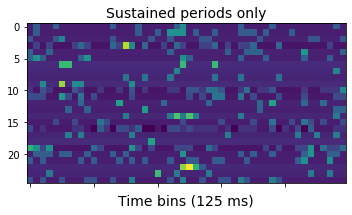

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.imshow(unit_mx_su[:, 0:100:2])
ax.set_xlabel('Time bins (125 ms)', fontsize=14)
ax.set_title('Sustained activity', fontsize=14)
ax.set_xticklabels([])

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_sustained_mx.png' % session[-19:-6]), dpi=300)

In [57]:
# new way - PCA on all units
su_mx = unit_mx_su[:, 1::2].T
pca = decomposition.PCA(n_components=3)
pca.fit(su_mx)
X = pca.transform(su_mx)
sustained_act = X[:, 0]  # PC1 score

In [58]:
# smooth
k_width = 25  # sampled as events!

kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
sustained_act_sm = np.convolve(sustained_act, kernel, 'same') / kernel.sum()

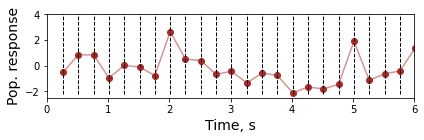

In [263]:
# selected for the manuscript
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
x_l, x_r = 0, 6
    
ax.plot(sound_events[:, 0], sustained_act, color='brown', alpha=0.5, lw=1.5)
ax.vlines(sound_events[:, 0], sustained_act.min(), sustained_act.max(), color='black', lw=1, ls='--', label='Stimulus')
ax.scatter(sound_events[:, 0], sustained_act, color='brown')
ax.set_xlim(x_l, x_r)
ax.set_ylim(-2.5, 4)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Pop. response', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_sust_response.png' % session[-19:-6]), dpi=300)

## Correlate with previous way

In [120]:
umap_file  = os.path.join(session_path, 'analysis', 'W1-W4_tSNE_UMAP.h5')

# test correlation with an older w1-w4 method
with h5py.File(umap_file, 'r') as f:
    w_mx = np.array(f['w_mx'])
    
w_mx.shape

(9599, 4)

Evoked: 0.704
Sustained: 0.940


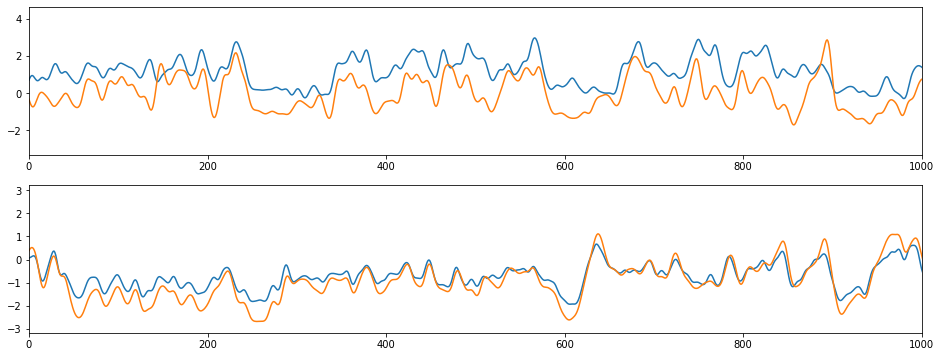

In [121]:
# t-SNE version
x_l, x_r = 0, 1000

fig, axes = plt.subplots(2, 1, figsize=(16, 6))

ax = axes[0]
ax.plot(evoked_resp_sm)
ax.plot(w_mx[:, 0])
ax.set_xlim(x_l, x_r)

ax = axes[1]
ax.plot(sustained_act_sm)
ax.plot(w_mx[:, 3])
ax.set_xlim(x_l, x_r)

print('Evoked: %.3f' % np.corrcoef(evoked_resp_sm, w_mx[:, 0])[0][1])
print('Sustained: %.3f' % np.corrcoef(sustained_act_sm, w_mx[:, 3])[0][1])

## 3. Response manifold

In [113]:
resp_manifold = np.column_stack([evoked_resp_sm, sustained_act_sm])
resp_manifold.shape

(9599, 2)

In [114]:
# compare with previous
umap_file  = os.path.join(session_path, 'analysis', 'W1-W4_tSNE_UMAP.h5')
with h5py.File(umap_file, 'r') as f:
    w_manifold = np.array(f['tSNE']['70'])
w_manifold.shape

(9599, 2)

In [115]:
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]

idxs_succ_ev = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_succ_ev = np.array(idxs_succ_ev)

Text(0, 0.5, 'Sustained')

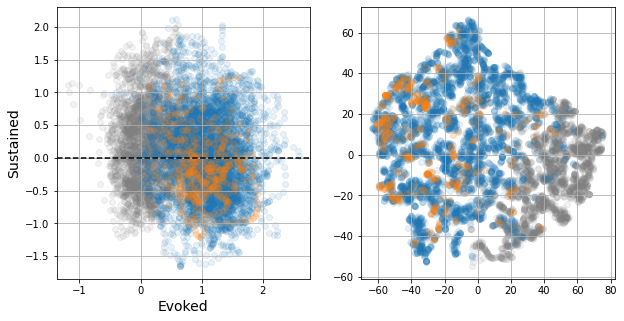

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, fit in enumerate([resp_manifold, w_manifold]):
    ax = axes[i]
    ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], alpha=0.1, color='gray')
    ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='tab:blue')
    #ax.scatter(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1], alpha=0.2, color='tab:orange')
    ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.2, color='tab:orange')
    ax.grid()

axes[0].axhline(0, ls='--', color='black')
#axes[0].axhline(resp_manifold[idxs_bgr_ev][:, 1].mean(), ls='--', color='tab:blue')
#axes[0].axhline(np.median(resp_manifold[idxs_succ_ev][:, 1]), ls='--', color='tab:orange')
axes[0].set_xlabel('Evoked', fontsize=14)
axes[0].set_ylabel('Sustained', fontsize=14)